


# Transfer Learning
In this notebook, we will perform transfer learning to train CIFAR-10 dataset on ResNet50 model available in Keras.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [ ]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.18.0


## Parameters

- Define the batch size
- Define the class (category) names

In [ ]:
BATCH_SIZE = 32
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Define some functions that will help us to create some visualizations.

In [ ]:
#Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]

  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]

    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

## Loading and Preprocessing Data
[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset has 32 x 32 RGB images belonging to 10 classes. We will load the dataset from Keras.

In [ ]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


### Visualize Dataset

Use the `display_image` to view some of the images and their class labels.

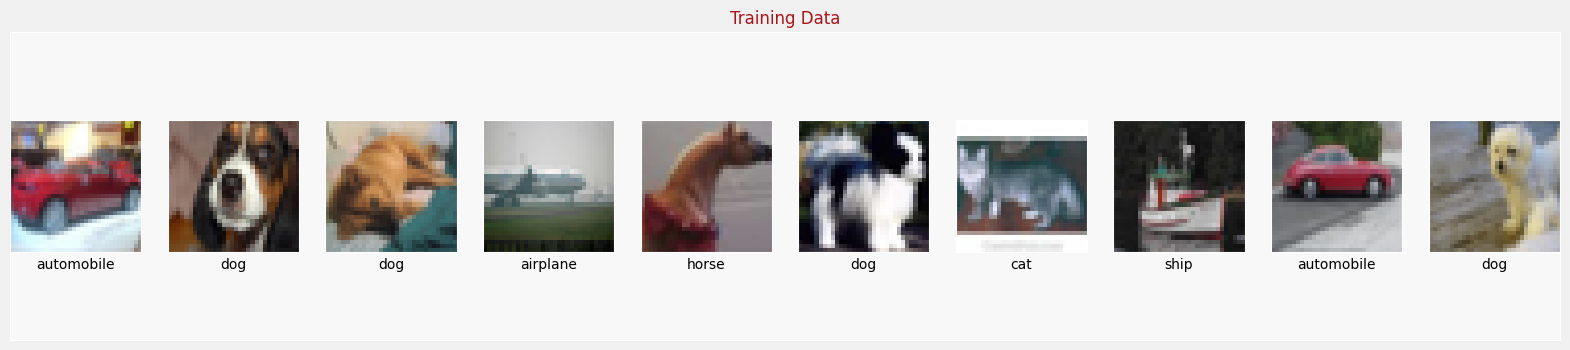

In [ ]:
display_images(training_images, training_labels, training_labels, "Training Data" )

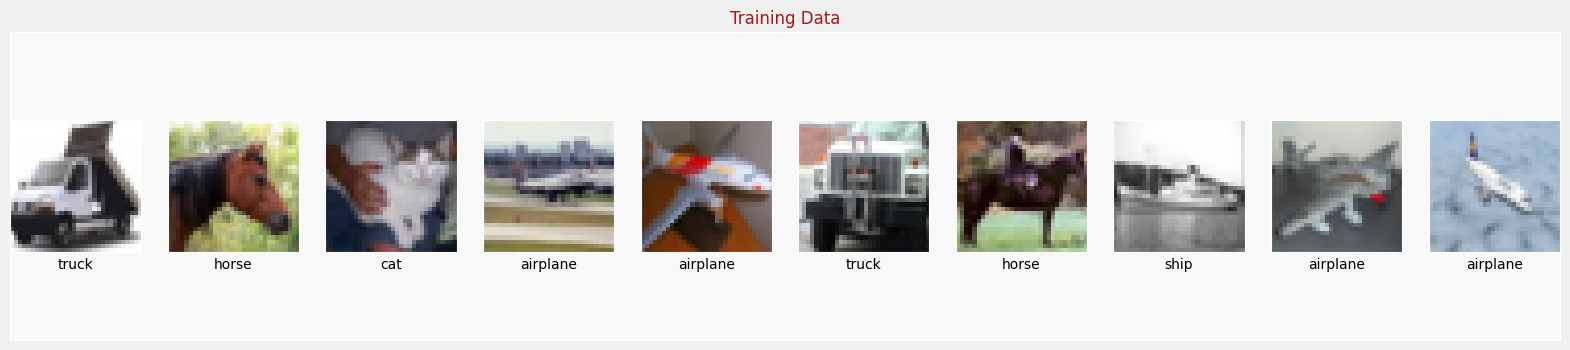

In [ ]:
display_images(validation_images, validation_labels, validation_labels, "Training Data" )

### Preprocess Dataset
Here, we'll perform normalization on images in training and validation set.
- We'll use the function [preprocess_input](https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py) from the ResNet50 model in Keras.

In [ ]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims


In [ ]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

In [ ]:
# Make sure images have shape (32, 32, 3)
training_images = np.expand_dims(training_images, -1)
training_labels = np.expand_dims(training_labels, -1)
print("Training_images shape:", training_images.shape)
print(training_images.shape[0], "train samples")
print(training_labels.shape[0], "test samples")


Training_images shape: (50000, 32, 32, 3, 1)
50000 train samples
50000 test samples


## Define the Network
We will be performing transfer learning on **ResNet50** available in Keras.
- We'll load pre-trained **imagenet weights** to the model.
- We'll choose to retain all layers of **ResNet50** along with the final classification layers.

In [ ]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights.
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it.
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)

  model.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])

  return model


model = define_compile_model()

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification (Dense)               │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,215,818 (100.01 MB)

 Trainable params: 26,162,698 (99.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Train the model

In [ ]:
EPOCHS = 3
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 289s 316ms/step - accuracy: 0.1072 - loss: 0.7476 - val_accuracy: 0.9347 - val_loss: 0.1902
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 222s 284ms/step - accuracy: 0.1123 - loss: 0.1059 - val_accuracy: 0.9320 - val_loss: 0.2094
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 222s 284ms/step - accuracy: 0.1133 - loss: 0.0371 - val_accuracy: 0.9406 - val_loss: 0.1925


In [ ]:
model.save('TransferLearning_project1.h5')

## Evaluate the Model

Calculate the loss and accuracy metrics using the model's `.evaluate` function.

In [ ]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.9473 - loss: 0.1717


In [ ]:
print("Training labels shape:", training_labels.shape)
print("Validation labels shape:", validation_labels.shape)


Training labels shape: (50000,)
Validation labels shape: (10000,)


In [ ]:
# Normalize the images to the range [0, 1]
training_images = training_images.astype('float32') / 255.0
validation_images = validation_images.astype('float32') / 255.0

# Flatten the labels
training_labels = np.squeeze(training_labels)  # Fix shape from (50000, 1, 1) to (50000,)
validation_labels = np.squeeze(validation_labels)  # Fix shape from (10000, 1, 1) to (10000,)

# Make sure images have shape (32, 32, 3)
training_images = np.expand_dims(training_images, -1)
training_labels = np.expand_dims(training_labels, -1)
print("Training_images shape:", training_images.shape)
print(training_images.shape[0], "train samples")
print(training_labels.shape[0], "test samples")



Training_images shape: (50000, 32, 32, 3, 1, 1)
50000 train samples
50000 test samples


Generating predictions for detailed metrics...
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step
Classification Report:
              precision    recall  f1-score   support

    airplane       0.96      0.96      0.96      1000
  automobile       0.96      0.98      0.97      1000
        bird       0.97      0.92      0.95      1000
         cat       0.92      0.86      0.89      1000
        deer       0.95      0.95      0.95      1000
         dog       0.86      0.96      0.91      1000
        frog       0.97      0.96      0.97      1000
       horse       0.97      0.96      0.97      1000
        ship       0.96      0.98      0.97      1000
       truck       0.98      0.94      0.96      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

Precision: 0.9500460031443198
Recall: 0.949
F1 Score: 0.9490278902692966


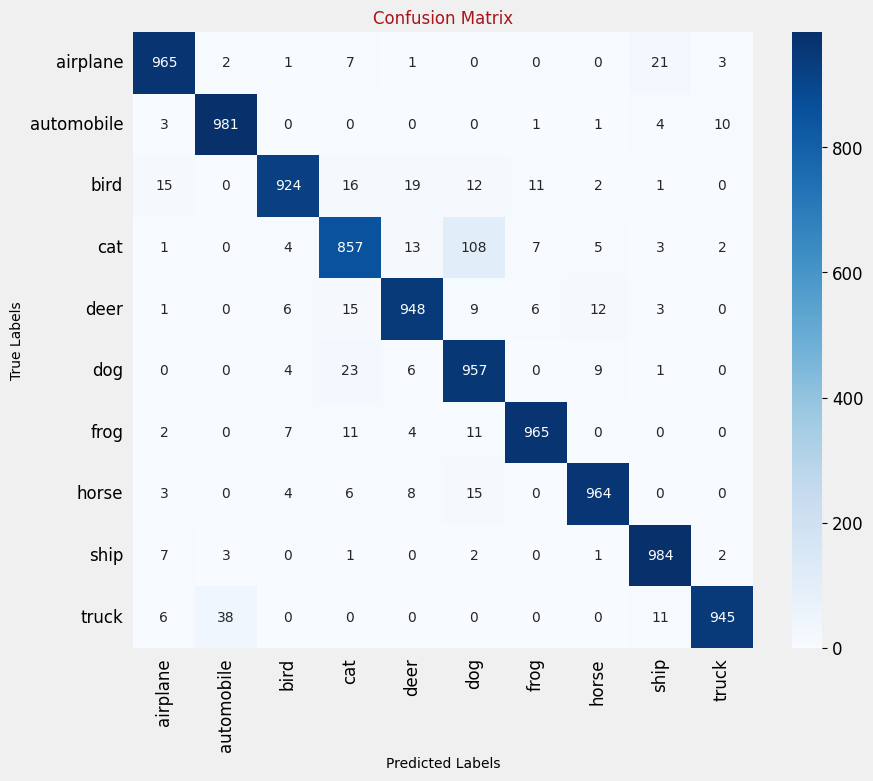

In [ ]:
# Generate predictions
print("Generating predictions for detailed metrics...")
y_pred = model.predict(valid_X)  # Use validation images, not labels
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class indices

# Classification Report
print("Classification Report:")
print(classification_report(validation_labels, y_pred_classes, target_names=classes))

# Calculate Precision, Recall, and F1 Score
precision = precision_score(validation_labels, y_pred_classes, average='weighted')
recall = recall_score(validation_labels, y_pred_classes, average='weighted')
f1 = f1_score(validation_labels, y_pred_classes, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Confusion Matrix
cm = confusion_matrix(validation_labels, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### Plot Loss and Accuracy Curves

Plot the loss (in blue) and validation loss (in green).

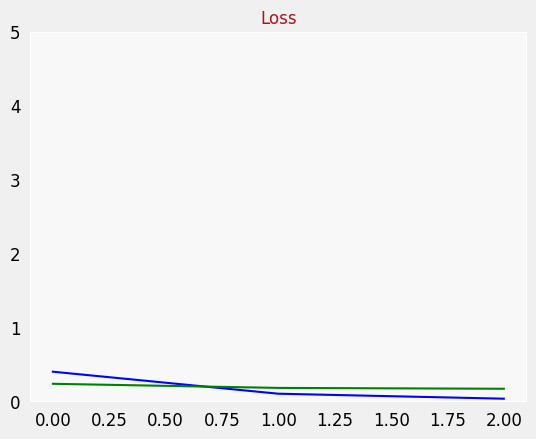

In [ ]:
plot_metrics("loss", "Loss")

Plot the training accuracy (blue) as well as the validation accuracy (green).

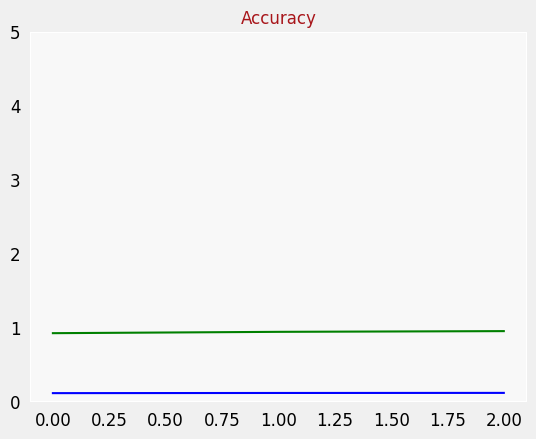

In [ ]:
plot_metrics("accuracy", "Accuracy")

### Visualize predictions
We can take a look at the predictions on the validation set.

157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step


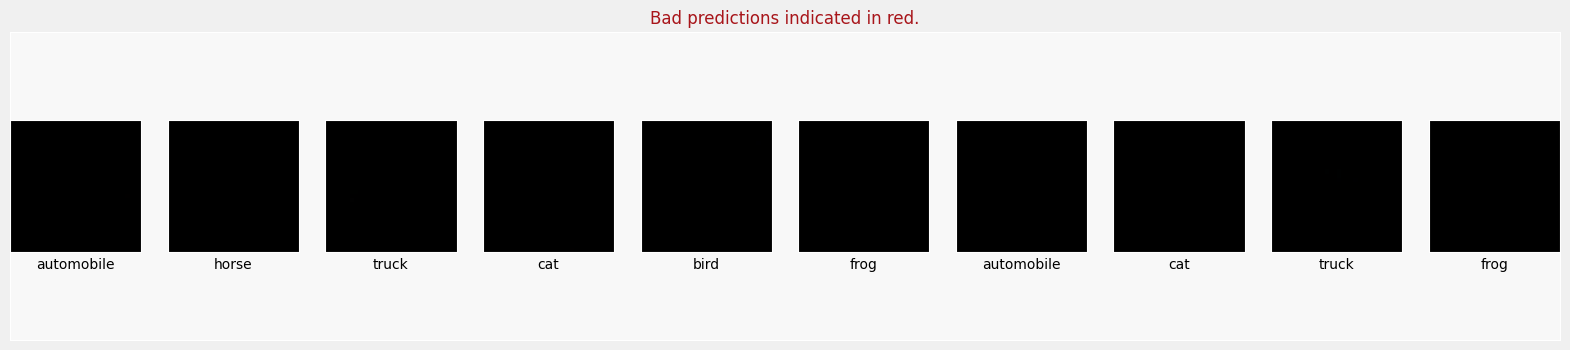

In [ ]:
probabilities = model.predict(valid_X, batch_size=64)
probabilities = np.argmax(probabilities, axis = 1)

display_images(validation_images, probabilities, validation_labels, "Bad predictions indicated in red.")

Deep CNN Test Loss: 0.5327, Test Accuracy: 84.70%
Transfer Learning Test Loss: 0.1675, Test Accuracy: 94.87%
               Model  Test Loss  Test Accuracy
0           Deep CNN   0.532729      84.700000
1  Transfer Learning   0.167538      94.870001


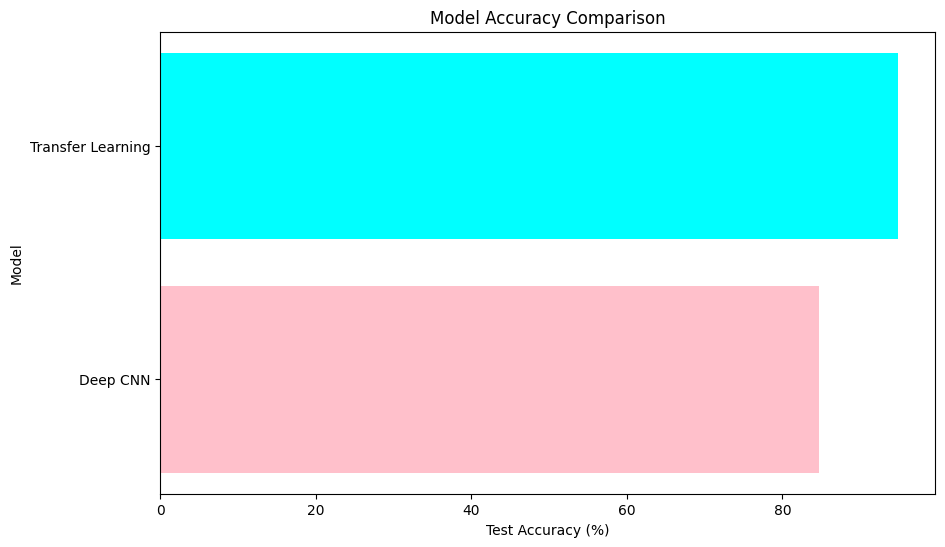

In [10]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input
import pandas as pd

# Load the saved models
model_deep_loaded = load_model('/content/group2project1/deep_cnn_model.h5')
model_tl_loaded = load_model('/content/group2project1/TransferLearning_project1.h5')

# Load and preprocess the CIFAR-10 test data
(_, _), (x_test, y_test) = cifar10.load_data()
x_test = x_test.astype('float32') / 255.0

# One-hot encode the target variable (y_test)
y_test = to_categorical(y_test, num_classes=10)

# Load and preprocess validation data (this was missing)
(_, _), (validation_images, validation_labels) = cifar10.load_data() # Load validation data
valid_X = preprocess_input(validation_images) # Preprocess validation data


# Evaluate the models on the test set
score_deep = model_deep_loaded.evaluate(x_test, y_test, verbose=0)
score_tl = model_tl_loaded.evaluate(valid_X, validation_labels, verbose=0)

# Print the results
print(f"Deep CNN Test Loss: {score_deep[0]:.4f}, Test Accuracy: {score_deep[1]*100:.2f}%")
print(f"Transfer Learning Test Loss: {score_tl[0]:.4f}, Test Accuracy: {score_tl[1]*100:.2f}%")

# ... (rest of your code) ...

results_comparison = [
    {'Model': 'Deep CNN', 'Test Loss': score_deep[0], 'Test Accuracy': score_deep[1] * 100},
    {'Model': 'Transfer Learning', 'Test Loss': score_tl[0], 'Test Accuracy': score_tl[1] * 100}
]

# Create a DataFrame for comparison
df_comparison = pd.DataFrame(results_comparison)

# Display the comparison table
print(df_comparison)

# Plot the comparison of model accuracies
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(df_comparison['Model'], df_comparison['Test Accuracy'], color=['pink', 'cyan'])
plt.xlabel('Test Accuracy (%)')
plt.ylabel('Model')
plt.title('Model Accuracy Comparison')
plt.show()